# "Cross-validation" des modèles

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Hyper-parametres
learning_rate = 0.04
num_epochs = 400
N = 200
N_cv = 40
seed = 42
batch_size = N//4
#batch_size = N//2
N_test = 0
N_test = 1000
N_scan = 9
bias = True


p0 = 0.05 #lapse rate
theta0 = 0
wt = np.pi/20
theta_std = np.pi/6



## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed=seed):
    np.random.seed(42)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p #add lapse rate
    y = np.random.rand(N) < p #generate data
    return theta, p, y

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2): #-2 ?
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))

    def forward(self, theta):
        out = self.logit0.sigmoid()/2 + (1-self.logit0.sigmoid())*self.linear(theta).sigmoid()
        return out
        

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader))
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [5]:
torch.sigmoid(torch.tensor([-3.]))

tensor([0.0474])

In [6]:
%%timeit
theta, p, y = get_data()

61.6 µs ± 5.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y,verbose=True) 

Iteration: 0 - Loss: 0.65054
Iteration: 12 - Loss: 0.57401
Iteration: 24 - Loss: 0.52631
Iteration: 36 - Loss: 0.49265
Iteration: 48 - Loss: 0.46794
Iteration: 60 - Loss: 0.44924
Iteration: 72 - Loss: 0.43507
Iteration: 84 - Loss: 0.42399
Iteration: 96 - Loss: 0.41543
Iteration: 108 - Loss: 0.40849
Iteration: 120 - Loss: 0.40308
Iteration: 132 - Loss: 0.39872
Iteration: 144 - Loss: 0.39520
Iteration: 156 - Loss: 0.39225
Iteration: 168 - Loss: 0.38996
Iteration: 180 - Loss: 0.38807
Iteration: 192 - Loss: 0.38648
Iteration: 204 - Loss: 0.38523
Iteration: 216 - Loss: 0.38417
Iteration: 228 - Loss: 0.38334
Iteration: 240 - Loss: 0.38257
Iteration: 252 - Loss: 0.38200
Iteration: 264 - Loss: 0.38152
Iteration: 276 - Loss: 0.38114
Iteration: 288 - Loss: 0.38083
Iteration: 300 - Loss: 0.38056
Iteration: 312 - Loss: 0.38034
Iteration: 324 - Loss: 0.38025
Iteration: 336 - Loss: 0.38002
Iteration: 348 - Loss: 0.37990
Iteration: 360 - Loss: 0.37983
Iteration: 372 - Loss: 0.37971
Iteration: 384 - L

In [8]:
with torch.no_grad():
    if bias: print('bias', logistic_model.linear.bias.item())
    print('slope', logistic_model.linear.weight.item())    
    print('p0', torch.sigmoid(logistic_model.logit0).item())


bias 0.042573745578717175
slope 5.689508907400686
p0 0.004477626960253656


loss= 0.379603339398


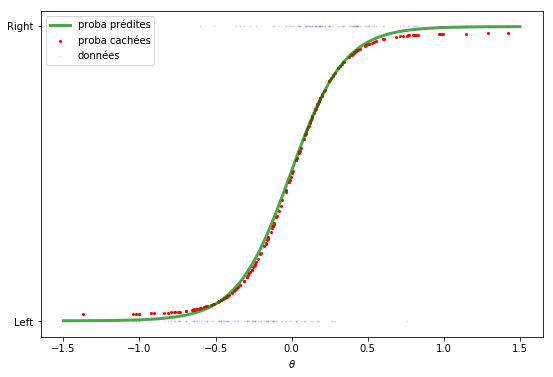

In [9]:
print('loss=', loss)
plt.figure(figsize = (9,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


In [10]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

2.91 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## validation

loss= tensor(0.3795, grad_fn=<BinaryCrossEntropyBackward>)


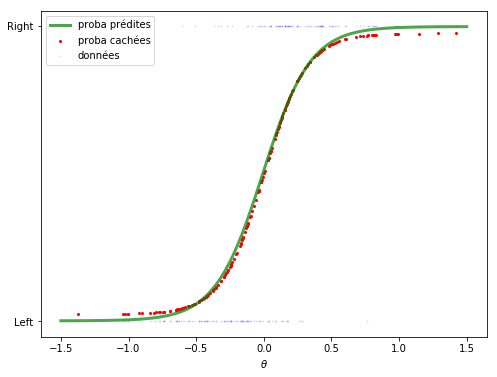

In [11]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [12]:
Ns = np.logspace(1, 3, N_scan, base=10)

Ns_, losses, loss_Ps, loss_P0s = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
    
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        loss_P0s.append(loss_P0)
        Ns_.append(N_)
        loss_Ps.append(loss_P)
        losses.append(loss)
    

N: 10, Loss: 0.47829, loss_P: 0.47256, loss_P0: 0.38791
N: 17, Loss: 0.44220, loss_P: 0.43757, loss_P0: 0.38791
N: 31, Loss: 0.38900, loss_P: 0.39525, loss_P0: 0.38791
N: 56, Loss: 0.38369, loss_P: 0.39259, loss_P0: 0.38791
N: 100, Loss: 0.38602, loss_P: 0.39238, loss_P0: 0.38791
N: 177, Loss: 0.38914, loss_P: 0.39295, loss_P0: 0.38791
N: 316, Loss: 0.38627, loss_P: 0.39015, loss_P0: 0.38791
N: 562, Loss: 0.38235, loss_P: 0.38866, loss_P0: 0.38791
N: 1000, Loss: 0.38265, loss_P: 0.39058, loss_P0: 0.38791


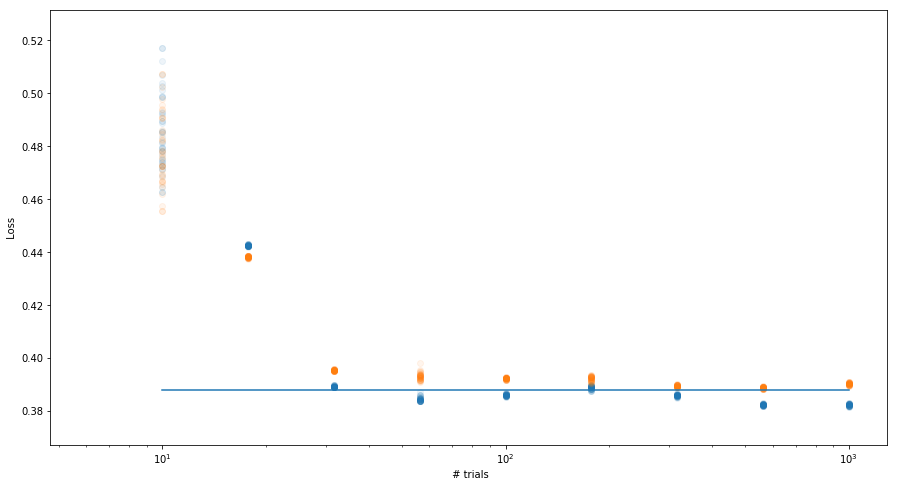

In [13]:
#plot

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(Ns_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du learning rate


In [14]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps, loss_P0s = [], [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        learning_rates_.append(learning_rate_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

learning_rate: 0.00400, Loss: 0.57576, loss_P: 0.57727, loss_P0: 0.38791
learning_rate: 0.00711, Loss: 0.42785, loss_P: 0.43149, loss_P0: 0.38791
learning_rate: 0.01265, Loss: 0.39463, loss_P: 0.39952, loss_P0: 0.38791
learning_rate: 0.02249, Loss: 0.39154, loss_P: 0.39677, loss_P0: 0.38791
learning_rate: 0.04000, Loss: 0.38466, loss_P: 0.39074, loss_P0: 0.38791
learning_rate: 0.07113, Loss: 0.38394, loss_P: 0.38956, loss_P0: 0.38791
learning_rate: 0.12649, Loss: 0.38298, loss_P: 0.38886, loss_P0: 0.38791
learning_rate: 0.22494, Loss: 0.38334, loss_P: 0.38982, loss_P0: 0.38791
learning_rate: 0.40000, Loss: 0.38383, loss_P: 0.39015, loss_P0: 0.38791


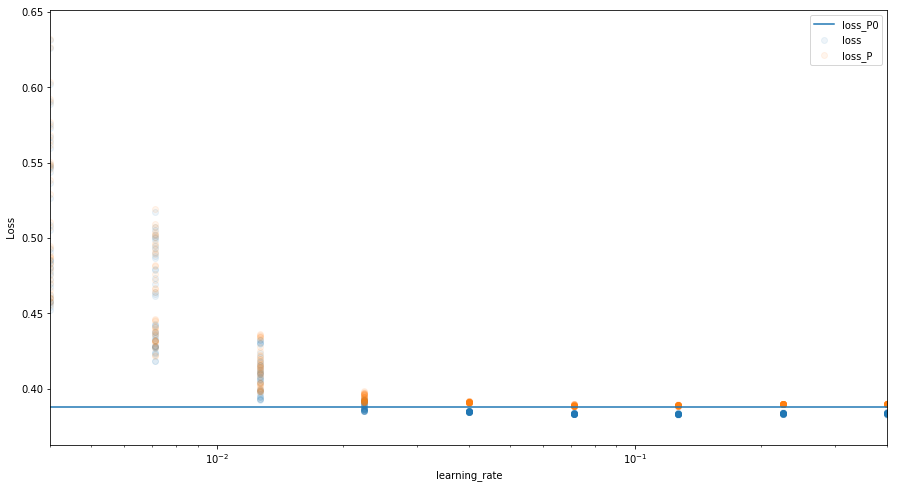

In [15]:
#influence du learning rate sur loss

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(learning_rates_, loss_P0s, label='loss_P0')
ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [16]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_P0s = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        num_epochss_.append(num_epochs_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

num_epochs: 40, Loss: 0.46346, loss_P: 0.46636, loss_P0: 0.38791
num_epochs: 71, Loss: 0.44446, loss_P: 0.44771, loss_P0: 0.38791
num_epochs: 126, Loss: 0.41614, loss_P: 0.42016, loss_P0: 0.38791
num_epochs: 224, Loss: 0.38585, loss_P: 0.39175, loss_P0: 0.38791
num_epochs: 400, Loss: 0.38494, loss_P: 0.39124, loss_P0: 0.38791
num_epochs: 711, Loss: 0.38307, loss_P: 0.38853, loss_P0: 0.38791
num_epochs: 1264, Loss: 0.38352, loss_P: 0.38964, loss_P0: 0.38791
num_epochs: 2249, Loss: 0.38371, loss_P: 0.39001, loss_P0: 0.38791
num_epochs: 4000, Loss: 0.38375, loss_P: 0.39003, loss_P0: 0.38791


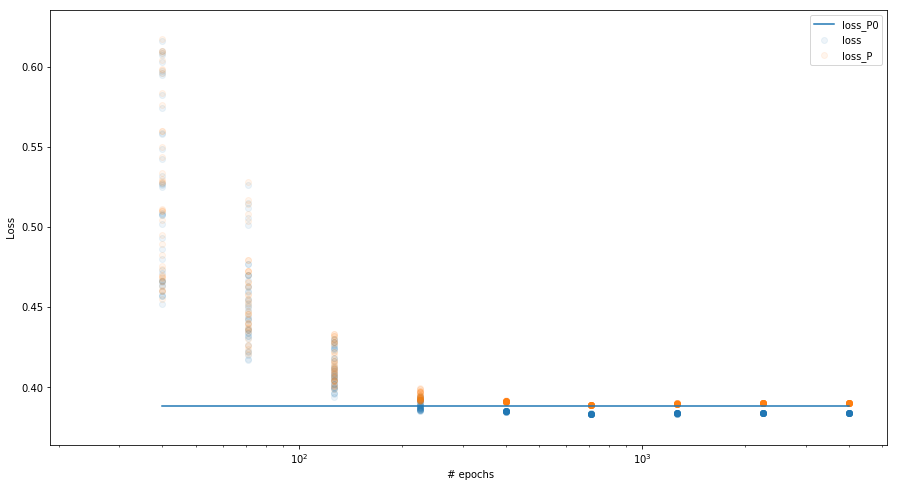

In [17]:
# influence du nbr d'epochs sur loss 
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(num_epochss_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # epochs')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [18]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps, loss_P0s = [], [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        batch_sizes_.append(batch_size_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

batch_size: 25, Loss: 0.38455, loss_P: 0.39050, loss_P0: 0.38791
batch_size: 32, Loss: 0.38417, loss_P: 0.39020, loss_P0: 0.38791
batch_size: 42, Loss: 0.38512, loss_P: 0.39131, loss_P0: 0.38791
batch_size: 54, Loss: 0.38507, loss_P: 0.39135, loss_P0: 0.38791
batch_size: 70, Loss: 0.38473, loss_P: 0.39094, loss_P0: 0.38791
batch_size: 91, Loss: 0.38457, loss_P: 0.39097, loss_P0: 0.38791
batch_size: 118, Loss: 0.38497, loss_P: 0.39119, loss_P0: 0.38791
batch_size: 154, Loss: 0.38472, loss_P: 0.39090, loss_P0: 0.38791
batch_size: 200, Loss: 0.38495, loss_P: 0.39133, loss_P0: 0.38791


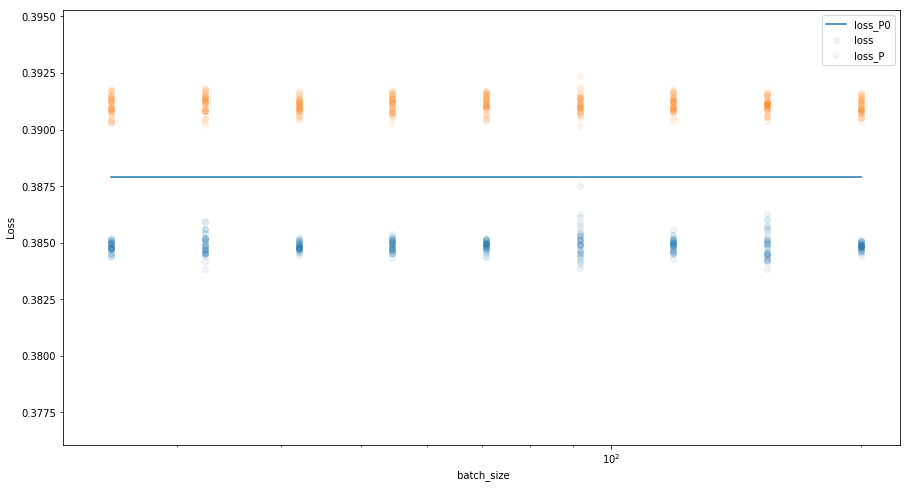

In [19]:
# influence de la taille du minibatch sur loss 

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(batch_sizes_, loss_P0s, label='loss_P0')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## Comparaison données générées/données prédites

### Tentative I

In [20]:
# p0 prediction/generate I

p0s = np.linspace(0,1,50)
p0_s = []


for p0_ in p0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
    p0_pred =  torch.sigmoid(logistic_model.logit0).item()     
        
    p0_s.append( p0_pred)
    print(f"p0 : {p0_pred: .5f}")



p0 :  0.02598
p0 :  0.01806
p0 :  0.01135
p0 :  0.01463
p0 :  0.02653
p0 :  0.01335
p0 :  0.01145
p0 :  0.01181
p0 :  0.02276
p0 :  0.02353
p0 :  0.01385
p0 :  0.02506
p0 :  0.01081
p0 :  0.01695
p0 :  0.01097
p0 :  0.01058
p0 :  0.02234
p0 :  0.02453
p0 :  0.01365
p0 :  0.02625
p0 :  0.02511
p0 :  0.00903
p0 :  0.01450
p0 :  0.01109
p0 :  0.01227
p0 :  0.02366
p0 :  0.01703
p0 :  0.01194
p0 :  0.02104
p0 :  0.01139
p0 :  0.01068
p0 :  0.01358
p0 :  0.01245
p0 :  0.01150
p0 :  0.01755
p0 :  0.01969
p0 :  0.02428
p0 :  0.01520
p0 :  0.01113
p0 :  0.01256
p0 :  0.02283
p0 :  0.01137
p0 :  0.01207
p0 :  0.01621
p0 :  0.02248
p0 :  0.01202
p0 :  0.00978
p0 :  0.02451
p0 :  0.01735
p0 :  0.01355


Text(0,0.5,'p0 prédit')

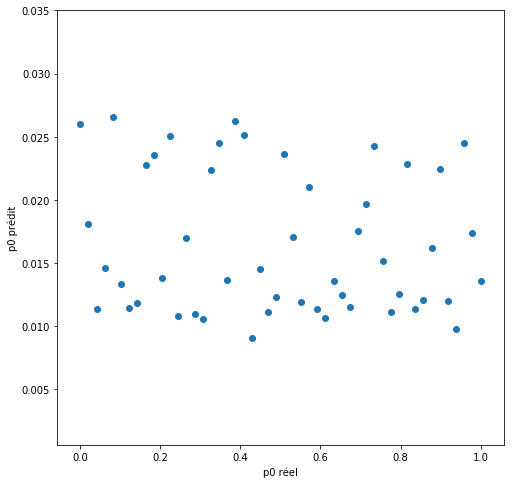

In [21]:
plt.figure(figsize = (8,8)) 
plt.scatter(p0s, p0_s)
plt.xlabel('p0 réel')
plt.ylabel('p0 prédit')


In [22]:
#theta0 prediction/generate 

theta0s = np.random.randn(50)
theta0_s = []

for theta0_ in theta0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    theta0_pred = logistic_model.linear.bias.item()
    theta0_s.append(theta0_pred)
        
    print(f" theta0: {theta0_pred:.5f}")
    

 theta0: -0.12363
 theta0: -0.13981
 theta0: -0.11440
 theta0: -0.11414
 theta0: -0.10956
 theta0: -0.11797
 theta0: -0.12728
 theta0: -0.13774
 theta0: -0.12052
 theta0: -0.13059
 theta0: -0.11950
 theta0: -0.11841
 theta0: -0.11719
 theta0: -0.11817
 theta0: -0.12069
 theta0: -0.11751
 theta0: -0.12960
 theta0: -0.11885
 theta0: -0.11416
 theta0: -0.12287
 theta0: -0.14162
 theta0: -0.11908
 theta0: -0.12925
 theta0: -0.11340
 theta0: -0.13013
 theta0: -0.11879
 theta0: -0.12534
 theta0: -0.13907
 theta0: -0.11701
 theta0: -0.12007
 theta0: -0.11888
 theta0: -0.11938
 theta0: -0.11700
 theta0: -0.12164
 theta0: -0.12519
 theta0: -0.12019
 theta0: -0.13572
 theta0: -0.11554
 theta0: -0.12079
 theta0: -0.11699
 theta0: -0.12332
 theta0: -0.11572
 theta0: -0.12251
 theta0: -0.13250
 theta0: -0.11537
 theta0: -0.12098
 theta0: -0.12024
 theta0: -0.12406
 theta0: -0.11943
 theta0: -0.13852


Text(0,0.5,'theta prédit')

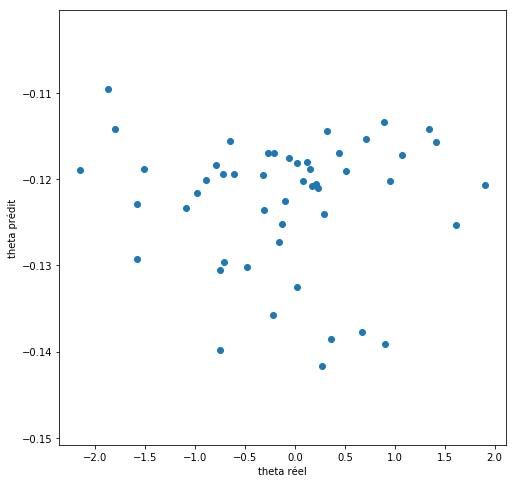

In [23]:
plt.figure(figsize = (8,8)) 
plt.scatter(theta0s, theta0_s)
plt.xlabel('theta réel')
plt.ylabel('theta prédit')


In [24]:
#wt prediction/generate 

wts = np.logspace(-1, 0.1, 50, base=10)
wt_s = []

for wt_ in wts:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)
        
    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    wt_pred = logistic_model.linear.weight.item()
        
    wt_s.append(wt_pred)
    print(f" wt:{wt_pred:.5f}")    

 wt:5.63571
 wt:5.67672
 wt:5.53632
 wt:5.54778
 wt:5.69041
 wt:5.65673
 wt:5.58743
 wt:5.73782
 wt:5.63235
 wt:5.88435
 wt:5.53728
 wt:5.83700
 wt:5.57004
 wt:5.66929
 wt:5.81589
 wt:5.60400
 wt:5.56057
 wt:5.54140
 wt:5.66406
 wt:5.59732
 wt:5.68047
 wt:5.84586
 wt:5.57682
 wt:5.58792
 wt:5.56583
 wt:5.64032
 wt:5.66789
 wt:5.58610
 wt:5.80458
 wt:5.62010
 wt:5.86206
 wt:5.53423
 wt:5.53365
 wt:5.67268
 wt:5.54562
 wt:5.56281
 wt:5.67925
 wt:5.60314
 wt:5.62433
 wt:5.55121
 wt:5.82007
 wt:5.58673
 wt:5.55373
 wt:5.87529
 wt:5.53134
 wt:5.82329
 wt:5.63239
 wt:5.58393
 wt:5.82469
 wt:5.53748


Text(0,0.5,'pente prédite')

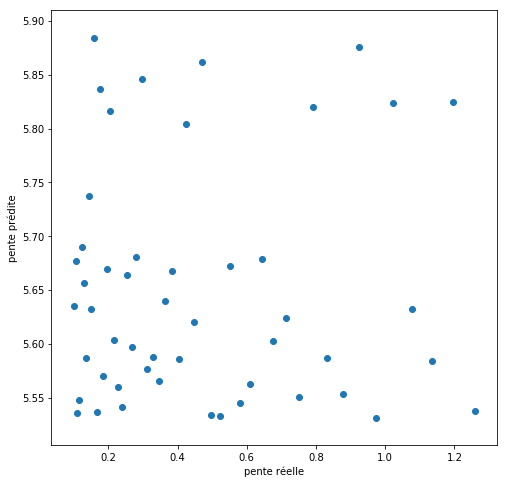

In [25]:
plt.figure(figsize = (8,8)) 
plt.scatter(wts, wt_s)
plt.xlabel('pente réelle')
plt.ylabel('pente prédite')


### Tentative II

p0 :  0.02690
p0 :  0.01716
p0 :  0.02081
p0 :  0.01186
p0 :  0.01419
p0 :  0.01149
p0 :  0.01817
p0 :  0.01183
p0 :  0.01349
p0 :  0.01833
p0 :  0.01517
p0 :  0.01133
p0 :  0.02017
p0 :  0.01240
p0 :  0.01005
p0 :  0.01056
p0 :  0.01204
p0 :  0.01816
p0 :  0.01922
p0 :  0.00995
p0 :  0.01399
p0 :  0.02410
p0 :  0.01536
p0 :  0.01218
p0 :  0.01793
p0 :  0.01208
p0 :  0.02212
p0 :  0.01637
p0 :  0.01455
p0 :  0.00924
p0 :  0.01217
p0 :  0.01470
p0 :  0.01066
p0 :  0.02151
p0 :  0.00963
p0 :  0.01305
p0 :  0.02071
p0 :  0.01388
p0 :  0.02492
p0 :  0.01691
p0 :  0.01123
p0 :  0.01173
p0 :  0.01874
p0 :  0.02330
p0 :  0.01165
p0 :  0.01197
p0 :  0.01053
p0 :  0.01048
p0 :  0.01404
p0 :  0.02073


Text(0,0.5,'p0 prédit')

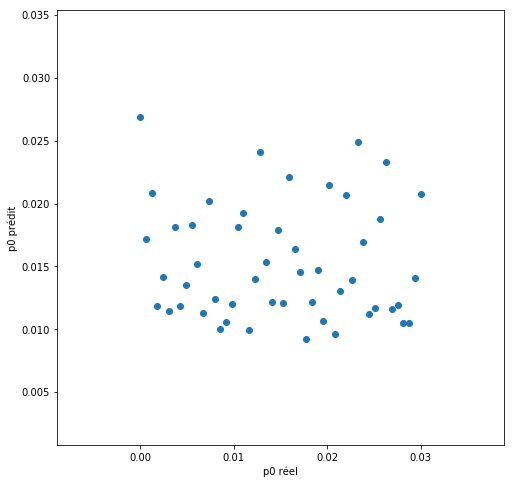

In [26]:
# p0 prediction/generate I

p0s = np.linspace(0,0.03,50)
p0_s = []


for p0_ in p0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
    p0_pred =  torch.sigmoid(logistic_model.logit0).item()     
        
    p0_s.append( p0_pred)
    print(f"p0 : {p0_pred: .5f}")

plt.figure(figsize = (8,8)) 
plt.scatter(p0s, p0_s)
plt.xlabel('p0 réel')
plt.ylabel('p0 prédit')


 theta0: -0.11526
 theta0: -0.11569
 theta0: -0.14341
 theta0: -0.13681
 theta0: -0.12355
 theta0: -0.14320
 theta0: -0.12391
 theta0: -0.12069
 theta0: -0.12230
 theta0: -0.12670
 theta0: -0.13187
 theta0: -0.11910
 theta0: -0.13269
 theta0: -0.11846
 theta0: -0.12697
 theta0: -0.12059
 theta0: -0.12881
 theta0: -0.13864
 theta0: -0.12854
 theta0: -0.12502
 theta0: -0.11814
 theta0: -0.12562
 theta0: -0.13311
 theta0: -0.12344
 theta0: -0.12822
 theta0: -0.13030
 theta0: -0.11435
 theta0: -0.11397
 theta0: -0.13381
 theta0: -0.14200
 theta0: -0.12753
 theta0: -0.11293
 theta0: -0.13390
 theta0: -0.14081
 theta0: -0.11971
 theta0: -0.11971
 theta0: -0.11983
 theta0: -0.11755
 theta0: -0.12431
 theta0: -0.13827
 theta0: -0.11915
 theta0: -0.12206
 theta0: -0.12854
 theta0: -0.12530
 theta0: -0.13735
 theta0: -0.10845
 theta0: -0.12083
 theta0: -0.12254
 theta0: -0.12123
 theta0: -0.12075


Text(0,0.5,'theta prédit')

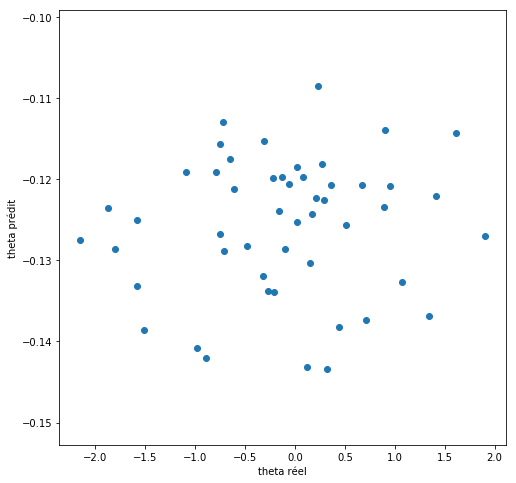

In [27]:
#theta0 prediction/generate 

theta0s = np.random.randn(50) #hum... pas terrible
theta0_s = []

for theta0_ in theta0s:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)

    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    theta0_pred = logistic_model.linear.bias.item()
    theta0_s.append(theta0_pred)
        
    print(f" theta0: {theta0_pred:.5f}")
    
plt.figure(figsize = (8,8)) 
plt.scatter(theta0s, theta0_s)
plt.xlabel('theta réel')
plt.ylabel('theta prédit')


 wt:5.82172
 wt:5.55995
 wt:5.77950
 wt:5.72404
 wt:5.62788
 wt:5.66354
 wt:5.54324
 wt:5.56271
 wt:5.75185
 wt:5.60719
 wt:5.53874
 wt:5.61666
 wt:5.59895
 wt:5.58369
 wt:5.57866
 wt:5.73096
 wt:5.57664
 wt:5.53819
 wt:5.86805
 wt:5.58693
 wt:5.68476
 wt:5.62330
 wt:5.56705
 wt:5.91218
 wt:5.57973
 wt:5.53572
 wt:5.73079
 wt:5.63017
 wt:5.74922
 wt:5.52570
 wt:5.57407
 wt:5.67502
 wt:5.65387
 wt:5.76294
 wt:5.89470
 wt:5.72391
 wt:5.53526
 wt:5.64684
 wt:5.79685
 wt:5.60981
 wt:5.90455
 wt:5.82630
 wt:5.87961
 wt:5.64634
 wt:5.57876
 wt:5.63746
 wt:5.56733
 wt:5.64492
 wt:5.54392
 wt:5.80606


Text(0,0.5,'pente prédite')

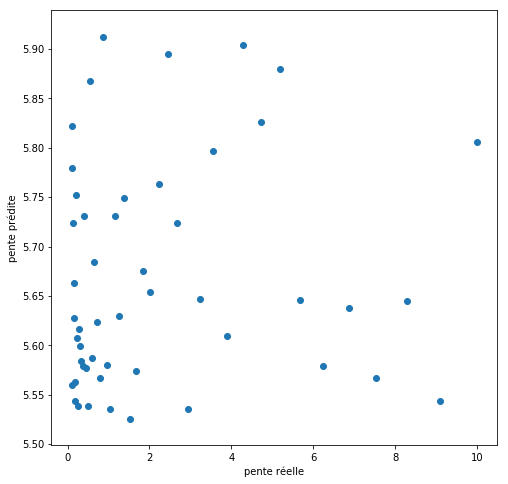

In [28]:
#wt prediction/generate 

wts = np.logspace(-1, 1, 50, base=10)
wt_s = []

for wt_ in wts:
    
    theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
    logistic_model, loss = fit_data(theta, y, verbose=False)
        
    if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        
    wt_pred = logistic_model.linear.weight.item()
        
    wt_s.append(wt_pred)
    print(f" wt:{wt_pred:.5f}") 
    
plt.figure(figsize = (8,8)) 
plt.scatter(wts, wt_s)
plt.xlabel('pente réelle')
plt.ylabel('pente prédite')
